### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from copy import deepcopy

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# Covid epidemic simulator - illustrative Leeds example

In [5]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.outbreak_recorder import WardComponent
from codit.population.covid import PersonCovid
import codit.society as society
import codit.society.alternatives
import codit.config

from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras

(access to real data on Leeds)

In [6]:
import pandas as pd
from codit import share_dir
DATA_PATH = share_dir() / 'codit' / 'data'
TIME_SERIES_WARDS = DATA_PATH / 'city' / 'population' / 'Timeseries_Leeds_wards.csv'

### Baseline config of the simulation

We want to set up Leeds in 2021, so:

In [7]:
CITY_OBSERVE = 'Leeds'
POP_SIZE = city_paras[CITY_OBSERVE]['population'] 
LOCKDOWN_LEVEL = 0.66   # proportion of classrooms and workplaces to close down for lockdown
COVID_TYPE = 'B.1.1.7'

Here's some baseline config that is informing these simulations:

In [8]:
codit.config.print_baseline_config()

CROSS_IMMUNITY {'other': {'other'}, 'SARS-CoV-2': {'B.1.1.7', 'SARS-CoV-2'}, 'B.1.1.7': {'B.1.1.7', 'SARS-CoV-2'}}
DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DEFAULT_COVID SARS-CoV-2
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY {'SARS-CoV-2': 0.025, 'B.1.1.7': 0.039}
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
VACCINATION_IMMUNITY {'AstraZeneca': {'B.1.1.7', 'SARS-CoV-2'}, 'Pfizer': {'B.1.1.7', 'SARS-CoV-2'}}
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


We build a Leeds population:

In [9]:
pop = CityPopulation(POP_SIZE, society.Society(), person_type=PersonCovid, 
                     lockdown_config={'classrooms': LOCKDOWN_LEVEL, 'workplaces': LOCKDOWN_LEVEL})

2021-03-19 07:07:27,524 INFO:Building a set of 317255 households from which to build a population
2021-03-19 07:07:32,021 INFO:There are 317255 households generated for accommodation buildings
2021-03-19 07:07:35,729 INFO:311176 households of mean size 2.55
2021-03-19 07:07:36,893 INFO:1944 classrooms of mean size 30.95
2021-03-19 07:07:37,213 INFO:130 care_homes of mean size 106.46
2021-03-19 07:07:38,184 INFO:92734 workplaces of mean size 5.63
2021-03-19 07:07:38,205 INFO:66.0% of workplaces closed by lockdown, leaving 31529 open.
2021-03-19 07:07:38,245 INFO:66.0% of classrooms closed by lockdown, leaving 660 open.
2021-03-19 07:07:38,292 INFO:Adding 343495 permanent contact groups
2021-03-19 07:07:38,431 INFO:Adding 39657 ephemeral contact pairs


Lets just check out the contact network a little more:

In [10]:
nets = [len(p.contacts) for p in pop.people]

print(f"""People typically come into physical contact with {np.median(nets):2.1f} people each day,
but on average {np.mean(nets):2.1f} people.
There are people seeing as many as {np.max(nets):2.0f} people each day""")

People typically come into physical contact with 3.0 people each day,
but on average 7.8 people.
There are people seeing as many as 143 people each day


### Finally ready to simulate:
We begin by seeding the simulation with Covid, and allowing this to spread for 21 days of 'burn-in' before beginning to report simulation results.

In [11]:
BURNIN_DAYS = 18
DAYS_MONTH = 30

In [12]:
WINTER_PREVALENCE = 1/50

We simulate a PCR policy from 2020 of test, trace, and isolate, but with better testing capacity. Contacts, however, are not tested themselves.

In [13]:
soc = society.alternatives.UKSociety(config=dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                                                 PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.4))

We use the 'Kent' variant of Covid:

In [14]:
disease = Covid(name=COVID_TYPE)

Combine these elements into our model, ready for simulation:

In [15]:
o_Jan_Feb = Outbreak(soc, disease, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)

2021-03-19 07:07:56,286 WARNING:Using a pre-existing population - does it have the right network structure?


We set up some additional reporting at the ward level:

In [16]:
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))

Lets 'burn-in' the disease:

In [17]:
o_burnin = Outbreak(soc, disease, n_days=BURNIN_DAYS, seed_size=int(POP_SIZE*WINTER_PREVALENCE),  population=pop)
o_burnin.simulate()

2021-03-19 07:08:36,228 WARNING:Using a pre-existing population - does it have the right network structure?
2021-03-19 07:08:54,246 INFO:Day 1, prop infected is 0.02, prop infectious is 0.0143
2021-03-19 07:09:46,435 INFO:Day 18, prop infected is 0.07, prop infectious is 0.0181


#### OK, now lets run a simulation:

In [18]:
o_Jan_Feb.simulate()

2021-03-19 07:09:51,911 INFO:Day 1, prop infected is 0.08, prop infectious is 0.0175
2021-03-19 07:12:07,884 INFO:Day 51, prop infected is 0.13, prop infectious is 0.0040
2021-03-19 07:12:29,501 INFO:Day 60, prop infected is 0.14, prop infectious is 0.0027


2021-03-19 07:12:31,444 INFO: Realized R0 of early infections is 0.91
2021-03-19 07:12:31,445 INFO: 13.6 percent of the proportion was infected during the epidemic


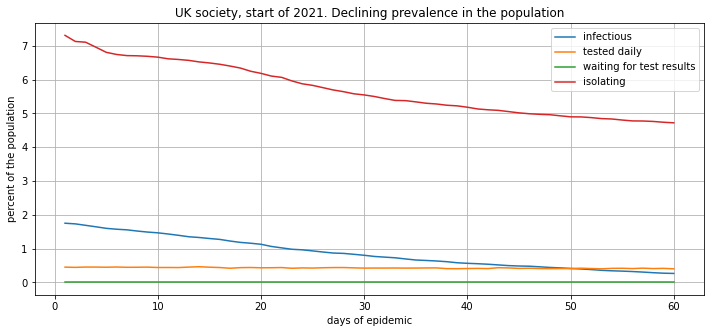

In [19]:
o_Jan_Feb.recorder.plot(title='UK society, start of 2021. Declining prevalence in the population')

In [20]:
ward_results = o_Jan_Feb.recorder.components[-1]

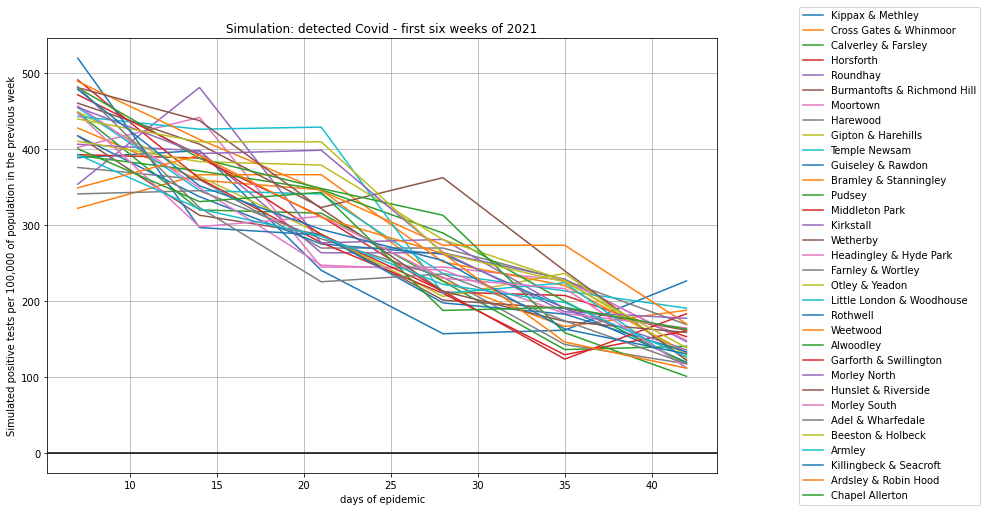

In [21]:
SIX_WEEKS = 6 * 7
ward_results.plot_weekly_positivity(SIX_WEEKS, title='First size weeks of 2021')

How does this stack up against the real ward-level data:

In [22]:
df_wards = pd.read_csv(TIME_SERIES_WARDS,index_col=0)

df_wards.drop(columns = [c for c in df_wards.columns if '2020' in c], inplace=True)
df_wards.drop(columns = df_wards.columns[-1:], inplace=True)  # here we remove the final datapoint which is < 1 week
df_wards.columns=[c[-10:] for c in df_wards.columns]

order = np.argsort(df_wards.iloc[:,-1:].values, axis=None) # get the order of the last column
df_wards = df_wards.iloc[np.flip(order)]     # sort the dataframe in decending order

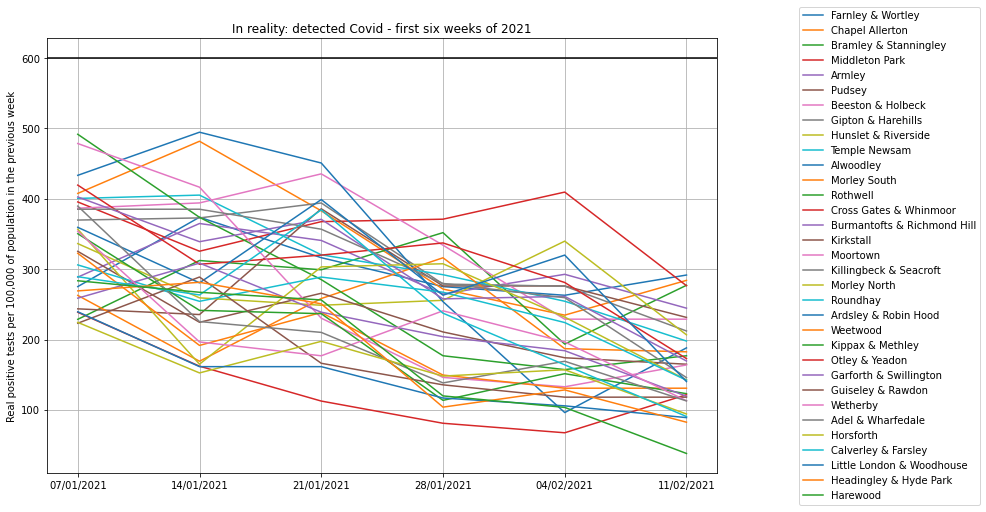

In [23]:
ax = df_wards.T.plot(title="In reality: detected Covid - first six weeks of 2021", 
                              figsize=(12,8), grid=True)
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
ax.set_ylabel("Real positive tests per 100,000 of population in the previous week")
_ = ax.axhline(600, color='k')

In [24]:
for p in pop.people:
    # We remove history:
    p.infector = None

### Lets press on ...

In [25]:
from codit.society.lateral import LateralFlowUK

In [26]:
for p in pop.people:
    # stop recursion ...
    p.infector = None

In [27]:
soc_March_April = soc #LateralFlowUK(config=dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
              #                     PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.4))

In [28]:
pop.set_structure(soc_March_April, lockdown_config={'classrooms': 0, 'workplaces': 0.66})

2021-03-19 07:12:34,504 INFO:66.0% of workplaces closed by lockdown, leaving 31529 open.
2021-03-19 07:12:34,541 INFO:0% of classrooms closed by lockdown, leaving 1944 open.
2021-03-19 07:12:34,584 INFO:Adding 344779 permanent contact groups
2021-03-19 07:12:34,730 INFO:Adding 39657 ephemeral contact pairs


Combine these elements into our model, ready for simulation:

In [29]:
o_March_April = Outbreak(soc_March_April, disease, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)

We set up some additional reporting at the ward level:

In [30]:
o_March_April.recorder.add_component(WardComponent(o_March_April))

#### Vaccinations to date:

In [31]:
for p in pop.people:
    if p.age > 60:
        p.vaccinate_with('AstraZeneca')

### Lets fast-forward through March and April:

In [32]:
o_March_April.simulate()

2021-03-19 07:13:23,613 INFO:Day 1, prop infected is 0.14, prop infectious is 0.0025
2021-03-19 07:15:32,760 INFO:Day 51, prop infected is 0.15, prop infectious is 0.0023
2021-03-19 07:15:54,733 INFO:Day 60, prop infected is 0.16, prop infectious is 0.0024


2021-03-19 07:15:55,803 INFO: Realized R0 of early infections is 1.07
2021-03-19 07:15:55,804 INFO: 15.5 percent of the proportion was infected during the epidemic


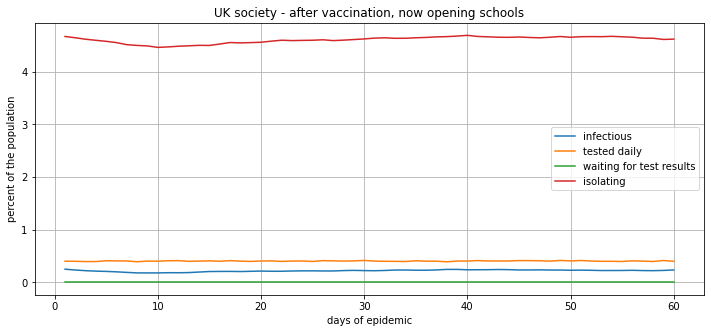

In [33]:
o_March_April.recorder.plot(title='UK society - after vaccination, now opening schools')

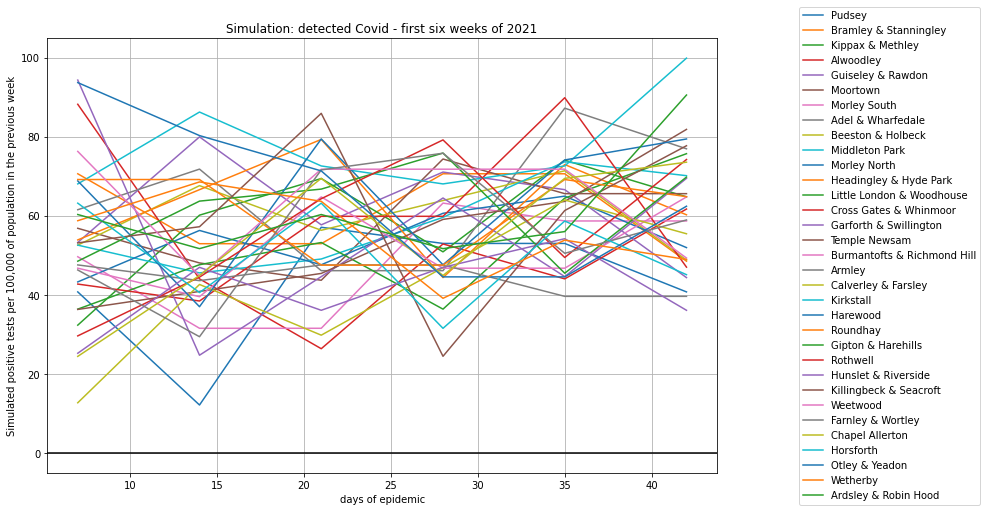

In [35]:
o_March_April.recorder.components[-1].plot_weekly_positivity(SIX_WEEKS, title='March, April')